In [5]:
import medusa
# from medusa.flux_analysis.flux_balance import optimize_ensemble

from __future__ import print_function
from __future__ import absolute_import

import cobra
import cobra.test
import numpy as np
import csv
import glob
import pickle
import pandas as pd
import math
import copy
import time
import random
import time
import sys
from sys import getsizeof

from copy import deepcopy
from collections import defaultdict
from cobra.flux_analysis import sample
from cobra.core.solution import get_solution
from cobra.flux_analysis.sampling import OptGPSampler
from cobra.manipulation.delete import *
from cobra.medium import find_boundary_types
from cobra.flux_analysis import pfba

from warnings import warn
from itertools import chain
from optlang.symbolics import Zero
from cobra.util import solver as sutil
from cobra.core.solution import get_solution

import logging
LOGGER = logging.getLogger(__name__)

In [3]:
import os
from cobra.test import create_test_model
from medusa.core.ensemble import Ensemble
from medusa.test.test_ensemble import construct_textbook_ensemble
from medusa.core.ensemble import Ensemble
from medusa.test.test_flux_balance import test_fba_single_return
from medusa.flux_analysis.flux_balance import optimize_ensemble

ImportError: No module named 'medusa'

In [ ]:
from cobra.util.solver import linear_reaction_coefficients
from cobra.core import DictList
from optlang.interface import OPTIMAL
import itertools
import random
from itertools import chain
import cobra.core.model
from medusa.test.test_reconstruct import load_universal_modelseed

In [13]:
# pFBA gapfiller
def pfba_gapfill(model, reaction_bag, likelihoods, obj=None, obj_lb=10., obj_constraint=False,
                 iters=1, tasks=None, task_lb=0.05, 
                 add_exchanges=True, extracellular='e'):
    
    start_time = time.time()
    # Save some basic network info for downstream membership testing
    orig_rxn_ids = set([str(x.id) for x in model.reactions])
    orig_cpd_ids = set([str(y.id) for y in model.metabolites])
    
    # Get model objective reaction ID
    if obj == None:
        obj = get_objective(model)
    else:
        obj = obj
    
    # Modify universal reaction bag
    new_rxn_ids = set()
    with reaction_bag as universal:
    
        # Remove overlapping reactions from universal bag, and reset objective if needed
        orig_rxns = list(copy.deepcopy(model.reactions))
        
        # Add pFBA to universal model and add model reactions
        add_pfba_likely(universal, likelihoods)
        
        universal.add_reactions(orig_rxns)
        
        # If previous objective not set as constraint, set minimum lower bound
        if obj_constraint == False:
            universal.reactions.get_by_id(obj).lower_bound = obj_lb
        
        # Run optimization of problem and save solution
        solution = universal.optimize()
#         print([bound.id for bound in universal.boundary if bound.lower_bound != 0.0 and bound.upper_bound != 0.0 and bound.id.startswith('EX')])
        
        # Identify which reactions carry flux in solution
        rxns = list(solution.fluxes.index)
        fluxes = list(solution.fluxes)
        for flux in range(0, len(fluxes)):
            if abs(fluxes[flux]) > 1e-6:
                new_rxn_ids |= set([rxns[flux]])
        
    # Screen new reaction IDs
    if obj in new_rxn_ids: new_rxn_ids.remove(obj)
    for rxn in orig_rxn_ids:
        try:
            new_rxn_ids.remove(rxn)
        except:
            continue
    
    # Get reactions and metabolites to be added to the model
    new_rxns = copy.deepcopy([reaction_bag.reactions.get_by_id(rxn) for rxn in new_rxn_ids])
    new_cpd_ids = set()
    for rxn in new_rxns: new_cpd_ids |= set([str(x.id) for x in list(rxn.metabolites)])
    new_cpd_ids = new_cpd_ids.difference(orig_cpd_ids)
    new_cpds = copy.deepcopy([reaction_bag.metabolites.get_by_id(cpd) for cpd in new_cpd_ids])
    
    # Copy model and gapfill
    new_model = copy.deepcopy(model)
    new_model.add_metabolites(new_cpds)
    new_model.add_reactions(new_rxns)
    
    duration = int(round(time.time() - start_time))
    print('Took ' + str(duration) + ' seconds to gapfill ' + str(len(new_rxn_ids)) + \
          ' reactions and ' + str(len(new_cpd_ids)) + ' metabolites.') 
    
    return {'NewModel':new_model, 'gaps':new_rxn_ids, 'mets':new_cpd_ids}
    
def add_pfba_likely(model, likelihoods, objective=None, fraction_of_optimum=1.0):
    """Add pFBA objective while accounting for reaction likelihoods

    Add objective to minimize the summed flux of all reactions to the
    current objective, the flux through each reaction is proportionally penalized
    based on it's likelihood score (value between 0 and 1).

    Parameters
    ----------
    model : cobra.Model
        The model to add the objective to
    objective :
        An objective to set in combination with the pFBA objective.
    likelihoods: dict 
        Keys: strings containing Reaction IDs
        Values: float with the range of 0.0 to 1.0 
    fraction_of_optimum : float
        Fraction of optimum which must be maintained. The original objective
        reaction is constrained to be greater than maximal_value *
        fraction_of_optimum.
    """
    if objective is not None:
        model.objective = objective
    if model.solver.objective.name == '_pfba_objective':
        raise ValueError('The model already has a pFBA objective.')
    sutil.fix_objective_as_constraint(model, fraction=fraction_of_optimum)
    reaction_variables = ((rxn.forward_variable, rxn.reverse_variable)
                          for rxn in model.reactions)
    variables = chain(*reaction_variables)
    dict1 = {}
    fail_report = []
    model_reactions = [rxn.id.split('_')[0] for rxn in model.reactions if rxn.id.startswith('rxn')]
    for v in variables:
        if set([str(v.name.split('_')[0])]).issubset(set(model_reactions)) and str(v.name.split('_')[0]).startswith('rxn'):
            rxn_id = (v.name.split('_')[0] + '_c')
            try:
                dict1[v] = max([0.0, 1.0 - likelihoods[rxn_id]])
            except:
                try:
                    dict1[v] = 1.0
                except:
                    print('FAILED')
                    pass
                pass
            
        elif str(v.name.split('_')[0]).startswith('DM'):
            dict1[v] = 1.0
        else:
            fail_report.append(1)
    model.objective = model.problem.Objective(Zero, direction='min', sloppy=True, name="_pfba_objective")
    model.objective.set_linear_coefficients(dict1)

def add_pfba(model, objective=None, fraction_of_optimum=1.0):
    """Add pFBA objective

    Add objective to minimize the summed flux of all reactions to the
    current objective.

    See Also
    -------
    pfba

    Parameters
    ----------
    model : cobra.Model
        The model to add the objective to
    objective :
        An objective to set in combination with the pFBA objective.
    fraction_of_optimum : float
        Fraction of optimum which must be maintained. The original objective
        reaction is constrained to be greater than maximal_value *
        fraction_of_optimum.
    """
    if objective is not None:
        model.objective = objective
    if model.solver.objective.name == '_pfba_objective':
        raise ValueError('The model already has a pFBA objective.')
    sutil.fix_objective_as_constraint(model, fraction=fraction_of_optimum)
    reaction_variables = ((rxn.forward_variable, rxn.reverse_variable)
                          for rxn in model.reactions)
    variables = chain(*reaction_variables)
    model.objective = model.problem.Objective(
        Zero, direction='min', sloppy=True, name="_pfba_objective")
    model.objective.set_linear_coefficients({v: 1.0 for v in variables})    

# Actually prune all unused metabolites and reactions (innate function does not work)
def removeUnused(model):
    removed_cpd = set()
    removed_rxn = set()
    unused_current_cpd = 1
    unused_current_rxn = 1
    
    while unused_current_cpd != 0 or unused_current_rxn != 0:
        unused_cpd = prune_unused_metabolites(model)
        removed_cpd |= set(unused_cpd)
        unused_rxn = prune_unused_reactions(model)
        removed_rxn |= set(unused_rxn)
        
        unused_current_cpd = len(unused_cpd)
        unused_current_rxn = len(unused_rxn)
    
    print('Pruned ' + str(len(removed_cpd)) + ' metabolites from model')
    print('Pruned ' + str(len(removed_rxn)) + ' reactions from model')
    
    return(list(removed_cpd), list(removed_rxn))

def set_media(model, media, universal, verbose=False):

    # Find and close all exchange reactions in the model
    model_rxns = [rxn.id for rxn in model.reactions]
    for rxn in model_rxns:
        if rxn.startswith('EX_') and rxn.endswith('_e'):
            model.reactions.get_by_id(rxn).lower_bound = 0.0

    # Check for existence of exchange reactions for the media metabolites in the model
    for metabolite in media:
        met = metabolite[1]+'_e'
        if 'EX_'+met in model_rxns:
            model.reactions.get_by_id('EX_'+met).lower_bound = -1000.
        else:
            # Create exchange reaction and add to model
            if verbose:
                print("added exchange rxn for " + met)
            new_exchange = cobra.Reaction('EX_'+met)
            new_exchange.name = met + ' exchange'
            met_obj = universal.metabolites.get_by_id(met)
            new_exchange.add_metabolites({met_obj:-1})
            new_exchange.lower_bound = -1000.
            new_exchange.upper_bound = 1000.
            model.add_reaction(new_exchange)
            model.repair()

def get_objective(model):
    
    if len(list(model.objective.variables)) == 0:
        raise IndexError('Model has no objective set.')
    
    expression = str(model.objective.expression).split()
    if 'reverse' in expression[0]:
        obj_id = expression[2].split('*')[-1]
    else:
        obj_id = expression[0].split('*')[-1]
            
    return obj_id

def copy(self):
    """Provides a partial 'deepcopy' of the Model.  All of the Metabolite,
    Gene, and Reaction objects are created anew but in a faster fashion
    than deepcopy
    """
    new = self.__class__()
    do_not_copy_by_ref = {"metabolites", "reactions", "genes", "notes",
                          "annotation"}
    for attr in self.__dict__:
        if attr not in do_not_copy_by_ref:
            new.__dict__[attr] = self.__dict__[attr]
    new.notes = deepcopy(self.notes)
    new.annotation = deepcopy(self.annotation)

    new.metabolites = DictList()
    do_not_copy_by_ref = {"_reaction", "_model"}
    for metabolite in self.metabolites:
        new_met = metabolite.__class__()
        for attr, value in iteritems(metabolite.__dict__):
            if attr not in do_not_copy_by_ref:
                new_met.__dict__[attr] = copy(
                    value) if attr == "formula" else value
        new_met._model = new
        new.metabolites.append(new_met)

    new.genes = DictList()
    for gene in self.genes:
        new_gene = gene.__class__(None)
        for attr, value in iteritems(gene.__dict__):
            if attr not in do_not_copy_by_ref:
                new_gene.__dict__[attr] = copy(
                    value) if attr == "formula" else value
        new_gene._model = new
        new.genes.append(new_gene)

    new.reactions = DictList()
    do_not_copy_by_ref = {"_model", "_metabolites", "_genes"}
    for reaction in self.reactions:
        new_reaction = reaction.__class__()
        for attr, value in iteritems(reaction.__dict__):
            if attr not in do_not_copy_by_ref:
                new_reaction.__dict__[attr] = copy(value)
        new_reaction._model = new
        new.reactions.append(new_reaction)
        # update awareness
        for metabolite, stoic in iteritems(reaction._metabolites):
            new_met = new.metabolites.get_by_id(metabolite.id)
            new_reaction._metabolites[new_met] = stoic
            new_met._reaction.add(new_reaction)
        for gene in reaction._genes:
            new_gene = new.genes.get_by_id(gene.id)
            new_reaction._genes.add(new_gene)
            new_gene._reaction.add(new_reaction)
    try:
        new._solver = deepcopy(self.solver)
        # Cplex has an issue with deep copies
    except Exception:  # pragma: no cover
        new._solver = copy(self.solver)  # pragma: no cover

    # it doesn't make sense to retain the context of a copied model so
    # assign a new empty context
    new._contexts = list()

    return new

def add_reactions(self, reaction_list):
    """Add reactions to the model.

    Reactions with identifiers identical to a reaction already in the
    model are ignored.

    The change is reverted upon exit when using the model as a context.

    Parameters
    ----------
    reaction_list : list
        A list of `cobra.Reaction` objects
    """
    def existing_filter(rxn):
        if rxn.id in self.reactions:
            LOGGER.warning(
                "Ignoring reaction '%s' since it already exists.", rxn.id)
            return False
        return True

    # First check whether the reactions exist in the model.
    pruned = DictList(filter(existing_filter, reaction_list))

    context = get_context(self)

    # Add reactions. Also take care of genes and metabolites in the loop.
    for reaction in pruned:
        reaction._model = self
        # Build a `list()` because the dict will be modified in the loop.
        for metabolite in list(reaction.metabolites):
            # TODO: Should we add a copy of the metabolite instead?
            if metabolite not in self.metabolites:
                self.add_metabolites(metabolite)
            # A copy of the metabolite exists in the model, the reaction
            # needs to point to the metabolite in the model.
            else:
                # FIXME: Modifying 'private' attributes is horrible.
                stoichiometry = reaction._metabolites.pop(metabolite)
                model_metabolite = self.metabolites.get_by_id(
                    metabolite.id)
                reaction._metabolites[model_metabolite] = stoichiometry
                model_metabolite._reaction.add(reaction)
                if context:
                    context(partial(
                        model_metabolite._reaction.remove, reaction))

        for gene in list(reaction._genes):
            # If the gene is not in the model, add it
            if not self.genes.has_id(gene.id):
                self.genes += [gene]
                gene._model = self

                if context:
                    # Remove the gene later
                    context(partial(self.genes.__isub__, [gene]))
                    context(partial(setattr, gene, '_model', None))

            # Otherwise, make the gene point to the one in the model
            else:
                model_gene = self.genes.get_by_id(gene.id)
                if model_gene is not gene:
                    reaction._dissociate_gene(gene)
                    reaction._associate_gene(model_gene)

    self.reactions += pruned

    if context:
        context(partial(self.reactions.__isub__, pruned))

    # from cameo ...
    self._populate_solver(pruned)

In [ ]:
univ_master = load_universal_modelseed()
set1 = set([rxn.id for rxn in univ_master.reactions])

In [8]:
univ_master = cobra.io.load_json_model("../../Lactobacillus/Data/universal_w_OK_rxns.json")
set1 = set([rxn.id for rxn in univ_master.reactions])

In [9]:
# Find all reactions missing from master universal from Mackinac/PATRIC gapfilled models
model_paths = glob.glob('../../Lactobacillus/models/*.xml')
set4 = set()
count = 0
for model_path in model_paths:
    model = cobra.io.read_sbml_model(model_path)
    set2 = set([rxn.id for rxn in model.reactions])
    set3 = set2.difference(set1)
    set4 = set4 | set3
    sys.stdout.write('\rN'+str(count)+' New: '+str(len(set3))+' Total: '+str(len(set4))+'    ')
    sys.stdout.flush()
    count = count+1

N1880 New: 134 Total: 281    

In [10]:
# Remove the exchange reactions, they will be added back later along with all other exchanges
set5 = set()
for rxn_id in set4:
    if rxn_id.startswith('rxn') or rxn_id.startswith('SK'):
        set5 = set5|set([rxn_id])

In [11]:
len(set5)

75

In [12]:
# We have all the missing reactions needed in the less expansive universal model
universal = cobra.io.load_json_model("../../Lactobacillus/Data/GramPosUni.json")
set5.difference(set([rxn.id for rxn in universal.reactions]))

{'SK_cpd11416_c'}

In [32]:
# We have the sink reaction in the gap models
genome_id = '220668.9'
model = cobra.io.read_sbml_model('../../Lactobacillus/gap_models/'+ genome_id +'.xml')
model.reactions.get_by_id('SK_cpd11416_c')

Reaction identifier,SK_cpd11416_c
Name,Biomass sink
Memory address,0x07ffca2728208
Stoichiometry,cpd11416_c <=> Biomass <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [13]:
# Copy from universal and add to univ_master
rxn_objs = []
for rxn_id in set5:
    if not rxn_id.startswith('SK'):
        rxn_obj = universal.reactions.get_by_id(rxn_id).copy()
        rxn_objs.append(rxn_obj)
univ_master.add_reactions(rxn_objs)

In [14]:
len(univ_master.reactions)

14709

In [15]:
cobra.io.save_json_model(univ_master, "../../Lactobacillus/Data/Near_complete_ModelSEED_universal.json")

In [37]:
medium = [
    'cpd00067',
    'cpd00001',
    'cpd00011',
    'cpd00007',
    'cpd00528',
    'cpd00205',
    'cpd00971',
    'cpd00254',
    'cpd00030',
    'cpd10515', 
    'cpd00063',
    'cpd03422',
    'cpd00644',
    'cpd01415',
    'cpd00029',
    'cpd00137',
    'cpd00443',
    'cpd00013',
    'cpd00009',
    'cpd00048',
    'cpd00182',
    'cpd00307',
    'cpd00311',
    'cpd00184',
    'cpd00249',
    'cpd00027', 
    # Metals and ions
    'cpd00030',
    'cpd00034',
    'cpd00048', # Sulfate
    'cpd00058',
    'cpd00063',
    'cpd00099',
    'cpd00149',
    'cpd00205',
    'cpd00254',
    'cpd00971',
    'cpd10515',
    'cpd10516',
    'cpd00028',# Heme
    'cpd00268' # H2S2O3
]

In [ ]:
# from medusa.test.test_reconstruct import load_universal_modelseed
# univ_master = load_universal_modelseed()
# genome_id = '220668.9'
# model = cobra.io.read_sbml_model('../../Lactobacillus/models/'+ genome_id +'.xml')
# missing_reaction = model.reactions.get_by_id('rxn06022_c').copy()
# univ_master.add_reactions([missing_reaction])

In [ ]:
sys.stdout.write('Load models...')

# universal = cobra.io.load_json_model("../../Lactobacillus/Data/GramPosUni.json")
universal = univ_master.copy()

genome_id = '220668.9'
# model = cobra.io.read_sbml_model('../../Lactobacillus/models/'+ genome_id +'.xml')
model = cobra.io.read_sbml_model('../../Lactobacillus/gap_models/'+ genome_id +'.xml')
likelihoods = pickle.load(open('../../Lactobacillus/likelihoods_py3/'+ genome_id +'.probs', "rb"))

sys.stdout.write('Set-up...')

# Ensure free diffusion of water
universal.reactions.get_by_id('rxn05319_c').name = "Water transport"
universal.reactions.get_by_id('rxn05319_c').bounds = (-1000., 1000.)
model.reactions.get_by_id('rxn05319_c').name = "Water transport"
model.reactions.get_by_id('rxn05319_c').bounds = (-1000., 1000.)

model.objective = model.reactions.get_by_id('bio1')

lower_bound=0.05
penalties=None
demand_reactions=False
exchange_reactions=False
flux_cutoff=1E-10
exchange_prefix='EX_'

sys.stdout.write('Add EXs...')
# Add Exchanges to Gapfiller
for met in universal.metabolites:
    base_met_id = met.id.split('_')[0]
    if 'EX_' + base_met_id + '_e' not in set([reaction.id for reaction in universal.reactions])\
    and base_met_id + '_e' in set([metabolite.id for metabolite in universal.metabolites]):
        # Create exchange reaction and add to model
        new_exchange = cobra.Reaction('EX_' + base_met_id + '_e')
        new_exchange.name = base_met_id + ' exchange'
        met_obj = universal.metabolites.get_by_id(base_met_id + '_e')
        new_exchange.add_metabolites({met_obj:-1})
        new_exchange.lower_bound = -1000.
        new_exchange.upper_bound = 1000.
        universal.add_reaction(new_exchange)
        universal.repair()
    elif 'EX_' + base_met_id + '_e' in set([reaction.id for reaction in universal.reactions]):
        universal.reactions.get_by_id('EX_'+base_met_id+'_e').upper_bound = 1.0*1000

In [83]:
models = []
set1 = set()
set2 = set()
unique = []
counter = 0
opt_list = []
pan_add_rxns = set()
pan_add_mets = set()
n = 100

for i in range(1,n+1):
    gapfiller = universal.copy()
    model_to_gapfill = model.copy()

    '''
    Add EXs to Universal (Create new objects)
    Add Media metabolites to model if not present (Copy from Universal)
    Add EXs to model (Copy from universal)
    Add Transporters to Model (Copy from Universal)
    '''

#     sys.stdout.write('Add EXs...')
#     # Add Exchanges to Gapfiller
#     for met in gapfiller.metabolites:
#         base_met_id = met.id.split('_')[0]
#         if 'EX_' + base_met_id + '_e' not in set([reaction.id for reaction in gapfiller.reactions])\
#         and base_met_id + '_e' in set([metabolite.id for metabolite in gapfiller.metabolites]):
#             # Create exchange reaction and add to model
#             new_exchange = cobra.Reaction('EX_' + base_met_id + '_e')
#             new_exchange.name = base_met_id + ' exchange'
#             met_obj = gapfiller.metabolites.get_by_id(base_met_id + '_e')
#             new_exchange.add_metabolites({met_obj:-1})
#             new_exchange.lower_bound = -1000.
#             new_exchange.upper_bound = 1000.
#             gapfiller.add_reaction(new_exchange)
#             gapfiller.repair()
#         elif 'EX_' + base_met_id + '_e' in set([reaction.id for reaction in gapfiller.reactions]):
#             gapfiller.reactions.get_by_id('EX_'+base_met_id+'_e').upper_bound = 1.0*1000

    sys.stdout.write('Add Mets...')
    # Add media metabolites to model_to_gapfill from gapfiller
    for base_met_id in medium:
        if base_met_id + '_e' not in set([metabolite.id for metabolite in model_to_gapfill.metabolites])\
        and base_met_id + '_e' in set([metabolite.id for metabolite in gapfiller.metabolites]):
            # Add metabolite from gapfiller
            MET = gapfiller.metabolites.get_by_id(base_met_id + '_e').copy()
            model_to_gapfill.add_metabolites([MET])
            model_to_gapfill.repair()
        if base_met_id + '_c' not in set([metabolite.id for metabolite in model_to_gapfill.metabolites])\
        and base_met_id + '_c' in set([metabolite.id for metabolite in gapfiller.metabolites]):
            # Add metabolite from gapfiller
            MET = gapfiller.metabolites.get_by_id(base_met_id + '_c').copy()
            model_to_gapfill.add_metabolites([MET])
            model_to_gapfill.repair()

    sys.stdout.write('Copy EXs...')
    # Add Exchanges to model_to_gapfill from gapfiller
    for met in model_to_gapfill.metabolites:
        base_met_id = met.id.split('_')[0]
        if 'EX_' + base_met_id + '_e' not in set([reaction.id for reaction in model_to_gapfill.reactions])\
        and 'EX_' + base_met_id + '_e' in set([reaction.id for reaction in gapfiller.reactions]):
            # Add Exchange from gapfiller
            EX = gapfiller.reactions.get_by_id('EX_' + base_met_id + '_e').copy()
            model_to_gapfill.add_reactions([EX])
            model_to_gapfill.repair()

    sys.stdout.write('Transporters...')
    # Identify transporters for each biolog component in the universal model
    # and pick one that will enable transport in the gapfilling problem.
    pick_transporter = {}
    transporters_in_universal = [rxn for rxn in gapfiller.reactions if len(rxn.compartments)>1]
    for base_met_id in medium:
        metabolite = model_to_gapfill.metabolites.get_by_id(base_met_id+'_c')
        rxns_with_metabolite = metabolite.reactions
        transport = False
        for rxn in rxns_with_metabolite:
            metabolites = [met_in_rxn.id for met_in_rxn in rxn.metabolites]
            if (base_met_id+'_e' in metabolites and base_met_id+'_c' in metabolites):
                transport = True

        if not transport:
            print("missing transporter for " + metabolite.name)
            for rxn in transporters_in_universal:
                metabolites = [met_in_rxn.id for met_in_rxn in rxn.metabolites]
                if (base_met_id+'_e' in metabolites and base_met_id+'_c' in metabolites):
                    pick_transporter[base_met_id] = rxn.id

    # Add the transporters to the model
    transporters_to_add = list(pick_transporter.values())
    transporter_list = []
    for rxn in transporters_to_add:
        transporter_list.append(gapfiller.reactions.get_by_id(rxn).copy())
    model_to_gapfill.add_reactions(transporter_list)

    # # remove the added transporters from the universal model
    # gapfiller.remove_reactions([gapfiller.reactions.get_by_id(rxn) for rxn in transporters_to_add])

    # input("Press Enter to continue...")

    original_objective = linear_reaction_coefficients(model_to_gapfill)
    # convert to IDs to avoid issues with model membership when these reactions are added to gapfiller
    original_objective = {rxn.id:original_objective[rxn] for rxn in original_objective.keys()}

    # get the reactions in the original model, which need to be removed from
    # the universal if present. This cannot catch identical reactions that do
    # not share IDs, so make sure your model and universal are in the same
    # namespace.
    rxns_to_remove = [rxn for rxn in gapfiller.reactions if rxn.id in \
                        [rxn.id for rxn in model_to_gapfill.reactions]]
    gapfiller.remove_reactions(rxns_to_remove)

    # get the list of reactions currently in the gapfiller, which are the ones
    # we will need to check for flux after solving the problem (e.g. these are
    # the reactions we are considering adding to the model)
    get_fluxes = [rxn.id for rxn in gapfiller.reactions]

    # add the reactions from the model to the gapfiller, which are not
    # included in the pFBA formulation, and thus flux is not penalized
    # through them.
    original_model_reactions = [rxn.copy() for rxn
                                in model_to_gapfill.reactions]
    gapfiller.add_reactions(original_model_reactions)
    original_reaction_ids = [reaction.id for reaction
                                in original_model_reactions]

    # Add the pFBA constraints and objective (minimizes sum of fluxes)
#     add_pfba(gapfiller)
    add_pfba_likely(gapfiller, likelihoods)

    # set the linear coefficients for reactions in the original model to 0
    coefficients = (gapfiller.objective
                    .get_linear_coefficients(gapfiller.variables))
    reaction_variables = (((gapfiller.reactions.get_by_id(reaction)
                            .forward_variable),
                           (gapfiller.reactions.get_by_id(reaction)
                            .reverse_variable))
                            for reaction in original_reaction_ids)
    variables = chain(*reaction_variables)
    for variable in variables:
        coefficients[variable] = 0.0 # might need to be 0.001
    gapfiller.objective.set_linear_coefficients(coefficients)

    ## set a constraint on flux through the original objective
    for reaction in original_objective.keys():
        print("Constraining lower bound for " + reaction)
        gapfiller.reactions.get_by_id(reaction).lower_bound = lower_bound

    # Close import for all exchanges
    exchange_reactions = [rxn for rxn in gapfiller.reactions if rxn.id.startswith(exchange_prefix)]
    for rxn in exchange_reactions:
        rxn.lower_bound = 0

    # Set the medium for this condition.
    # set_media(gapfiller, medium, universal)
    for ex_rxn in medium:
        gapfiller.reactions.get_by_id('EX_'+ex_rxn+'_e').lower_bound = -1.0*1000
        gapfiller.reactions.get_by_id('EX_'+ex_rxn+'_e').upper_bound = 1.0*1000

    # gapfill and get the solution
    iteration_solution = gapfiller.optimize()

    filtered_solution = {rxn:iteration_solution.x_dict[rxn] for rxn in\
       get_fluxes if abs(iteration_solution.x_dict[rxn]) > flux_cutoff}

    add_rxns = [gapfiller.reactions.get_by_id(rxn).copy() for \
                                    rxn in filtered_solution.keys()]

    def validate(original_model, reactions, lower_bound):
            with original_model as model:
                model.add_reactions(reactions)
                mets = [x.metabolites for x in reactions]
                all_keys = set().union(*(d.keys() for d in mets))
                model.add_metabolites(all_keys)
                model.slim_optimize()
                return (model.solver.status == OPTIMAL and
                        model.solver.objective.value >= lower_bound)

    # validate that the proposed solution restores flux through the
    # objective in the original model
    # set the bounds on the original model to represent media
    # and validate the gapfill solution
    for ex_rxn in [rxn for rxn in model_to_gapfill.reactions if rxn.id.startswith(exchange_prefix)]:
        ex_rxn.lower_bound = 0

    for ex_rxn in medium:
        model_to_gapfill.reactions.get_by_id('EX_'+ex_rxn+'_e').lower_bound = -1.0*1000
        model_to_gapfill.reactions.get_by_id('EX_'+ex_rxn+'_e').upper_bound = 1.0*1000
    # set_media(model_to_gapfill, medium, universal)

    print(len(add_rxns))

    if not validate(model_to_gapfill, [gapfiller.reactions.get_by_id(rxn.id).copy() for rxn in add_rxns], lower_bound):
        raise RuntimeError('Failed to validate gapfilled model, '
                            'try lowering the flux_cutoff through '
                            'inclusion_threshold')
    
    new_model = model_to_gapfill.copy()
    reactions = [gapfiller.reactions.get_by_id(rxn.id).copy() for rxn in add_rxns]
    new_model.add_reactions(reactions)
    mets = [x.metabolites for x in reactions]
    all_keys = set().union(*(d.keys() for d in mets))
    new_model.add_metabolites(all_keys)
    new_model.slim_optimize()
    
    new_model.id = 'member%d' % i
    models.append(new_model)

    out1 = len(add_rxns)
    out2 = len(all_keys)
    if out1 not in set1 or out2 not in set2:
        counter = counter + 1
    unique.append(counter)
    set1.add(out1)
    set2.add(out2)
    opt_list.append(new_model.slim_optimize())
    pan_add_rxns.update(set(rxn.id for rxn in add_rxns))
    pan_add_mets.update(set(met.id for met in all_keys))
    

Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
missing transporter for Adenosine
missing transporter for Guanosine
missing transporter for Thymidine
missing transporter for Uridine
missing transporter for Sulfate
missing transporter for Ca2+
missing transporter for Cl-
missing transporter for Heme
missing transporter for H2S2O3
Constraining lower bound for bio1
126
Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
missing transporter for Adenosine
missing

Constraining lower bound for bio1
124
Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
missing transporter for Adenosine
missing transporter for Guanosine
missing transporter for Thymidine
missing transporter for Uridine
missing transporter for Sulfate
missing transporter for Ca2+
missing transporter for Cl-
missing transporter for Heme
missing transporter for H2S2O3
Constraining lower bound for bio1
125
Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
mis

Constraining lower bound for bio1
127
Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
missing transporter for Adenosine
missing transporter for Guanosine
missing transporter for Thymidine
missing transporter for Uridine
missing transporter for Sulfate
missing transporter for Ca2+
missing transporter for Cl-
missing transporter for Heme
missing transporter for H2S2O3
Constraining lower bound for bio1
128
Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
mis

Constraining lower bound for bio1
125
Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
missing transporter for Adenosine
missing transporter for Guanosine
missing transporter for Thymidine
missing transporter for Uridine
missing transporter for Sulfate
missing transporter for Ca2+
missing transporter for Cl-
missing transporter for Heme
missing transporter for H2S2O3
Constraining lower bound for bio1
126
Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
mis

Constraining lower bound for bio1
127
Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
missing transporter for Adenosine
missing transporter for Guanosine
missing transporter for Thymidine
missing transporter for Uridine
missing transporter for Sulfate
missing transporter for Ca2+
missing transporter for Cl-
missing transporter for Heme
missing transporter for H2S2O3
Constraining lower bound for bio1
126
Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
mis

Constraining lower bound for bio1
126
Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
missing transporter for Adenosine
missing transporter for Guanosine
missing transporter for Thymidine
missing transporter for Uridine
missing transporter for Sulfate
missing transporter for Ca2+
missing transporter for Cl-
missing transporter for Heme
missing transporter for H2S2O3
Constraining lower bound for bio1
127
Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
mis

Constraining lower bound for bio1
125
Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
missing transporter for Adenosine
missing transporter for Guanosine
missing transporter for Thymidine
missing transporter for Uridine
missing transporter for Sulfate
missing transporter for Ca2+
missing transporter for Cl-
missing transporter for Heme
missing transporter for H2S2O3
Constraining lower bound for bio1
127
Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
mis

Constraining lower bound for bio1
126
Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
missing transporter for Adenosine
missing transporter for Guanosine
missing transporter for Thymidine
missing transporter for Uridine
missing transporter for Sulfate
missing transporter for Ca2+
missing transporter for Cl-
missing transporter for Heme
missing transporter for H2S2O3
Constraining lower bound for bio1
126
Add Mets...Copy EXs...Transporters...missing transporter for N2
missing transporter for Ca2+
missing transporter for Cobinamide
missing transporter for PAN
missing transporter for Thioglycolate
missing transporter for Acetate
missing transporter for Citrate
missing transporter for ABEE
missing transporter for Sulfate
mis

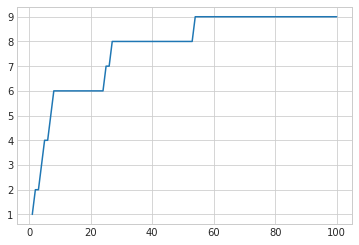

In [84]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

fig = plt.figure()
ax = plt.axes()

x = range(1,len(unique)+1)
ax.plot(x, unique)

In [85]:
opt_list

[39.55615391219864,
 39.48652364925774,
 39.48975332235195,
 39.55939498615823,
 39.485985421787596,
 39.559394986158395,
 39.49082999745426,
 39.48975332235487,
 39.48975332235184,
 39.558314569159954,
 39.55831456915987,
 39.48975332235192,
 39.48867670595662,
 39.55831456914927,
 39.5593949861584,
 39.48652364923528,
 39.5523733304048,
 39.55507367222603,
 39.488676705956685,
 39.48867670595665,
 39.4865236492688,
 39.497573121132255,
 39.49082999745414,
 39.49434216888899,
 39.55831456915996,
 39.552373330404755,
 39.48652364926871,
 39.48275636495958,
 39.555613784836964,
 39.49434216888142,
 39.489753322351895,
 39.558314569164104,
 39.5523733304041,
 39.55939498615842,
 39.55453357434279,
 39.55507367222616,
 39.50134323361635,
 39.48598542178125,
 39.55831456915999,
 39.48867670595775,
 39.489753322351895,
 39.555073672226094,
 39.55939498615885,
 39.48867670595671,
 39.48598542178128,
 39.48544720896645,
 39.48867670595668,
 39.554533574364534,
 39.4897533223519,
 39.489753322

In [90]:
len(pan_add_rxns)

147

In [89]:
len(pan_add_mets)

248

In [104]:
vars(model.reactions[0])

{'_compartments': None,
 '_forward_variable': None,
 '_gene_reaction_rule': '220668.9.peg.2750 or 220668.9.peg.1720',
 '_genes': {<Gene 220668.9.peg.1720 at 0x7ffc98484128>,
  <Gene 220668.9.peg.2750 at 0x7ffc984840f0>},
 '_id': 'rxn02201_c',
 '_lower_bound': 0.0,
 '_metabolites': {<Metabolite cpd00012_c at 0x7ffc9852e6a0>: 1.0,
  <Metabolite cpd00067_c at 0x7ffc9852e710>: 1.0,
  <Metabolite cpd00443_c at 0x7ffc9852e630>: -1.0,
  <Metabolite cpd00683_c at 0x7ffc9852e7b8>: 1.0,
  <Metabolite cpd02920_c at 0x7ffc9852e5f8>: -1.0},
 '_model': <Model 220668.9 at 0x7ffc98c0b2e8>,
 '_reverse_variable': None,
 '_upper_bound': 1000.0,
 'annotation': {},
 'name': '2-amino-4-hydroxy-6-hydroxymethyl-7,8-dihydropteridine-diphosphate:4-aminobenzoate 2-amino-4-hydroxydihydropteridine-6-methenyltransferase',
 'notes': {},
 'subsystem': '',
 'variable_kind': 'continuous'}

In [109]:
vars(list(model.reactions[0]._genes)[0])

{'_functional': True,
 '_id': '220668.9.peg.1720',
 '_model': <Model 220668.9 at 0x7ffc98c0b2e8>,
 '_reaction': {<Reaction rxn02200_c at 0x7ffc981bb080>,
  <Reaction rxn02201_c at 0x7ffc98453a20>},
 'annotation': {},
 'name': '3-phosphoshikimate 1-carboxyvinyltransferase (EC 2.5.1.19)',
 'notes': {}}

In [88]:
emodel = medusa.Ensemble(list_of_models=models, identifier='Plantarum_100')

In [110]:
emodel.to_pickle("plantarum_100.ensemble")

In [103]:
optimize_ensemble(emodel)

,EX_cpd00001_e,EX_cpd00002_e,EX_cpd00004_e,EX_cpd00005_e,EX_cpd00006_e,EX_cpd00007_e,EX_cpd00008_e,EX_cpd00009_e,EX_cpd00010_e,EX_cpd00011_e,...,rxn20662_c,rxn21635_c,rxn23024_c,rxn29150_c,rxn30062_c,rxn30594_c,rxn31310_c,rxn33749_c,rxn33937_c,rxn34447_c
member78,1000.0,0.0,0.0,0.0,0.0,55.563750,0.0,-49.134041,0.0,-870.175576,...,0.628116,0.000000,0.000000,-6.648133e-17,6.281161e-01,0.0,0.628116,0.0,13.985860,0.314058
member13,1000.0,0.0,0.0,0.0,0.0,55.626486,0.0,-49.050896,0.0,-863.333599,...,0.627053,0.000000,0.313527,-6.648133e-17,6.270532e-01,0.0,0.627053,0.0,13.962193,0.313527
member64,1000.0,0.0,0.0,0.0,0.0,55.626486,0.0,-49.050896,0.0,-863.333599,...,0.627053,0.313527,0.000000,0.000000e+00,6.270532e-01,0.0,0.627053,0.0,13.962193,0.313527
member68,1000.0,0.0,0.0,0.0,0.0,55.724583,0.0,-49.137396,0.0,-869.852632,...,0.628159,0.000000,0.314080,-6.648133e-17,6.281590e-01,0.0,0.628159,0.0,13.986815,0.314080
member69,1000.0,0.0,0.0,0.0,0.0,55.569061,0.0,-49.138738,0.0,-870.163166,...,0.628176,0.000000,0.314088,-1.329627e-16,4.763479e-16,0.0,0.000000,0.0,13.987197,0.314088
member70,1000.0,0.0,0.0,0.0,0.0,55.487516,0.0,-49.066629,0.0,-877.104003,...,0.627254,0.000000,0.313627,0.000000e+00,6.272544e-01,0.0,0.627254,0.0,13.966672,0.313627
member47,1000.0,0.0,0.0,0.0,0.0,55.626486,0.0,-49.050896,0.0,-863.333599,...,0.627053,0.000000,0.313527,0.000000e+00,6.270532e-01,0.0,0.627053,0.0,13.962193,0.313527
member71,1000.0,0.0,0.0,0.0,0.0,55.719257,0.0,-49.132700,0.0,-869.865072,...,0.628099,0.000000,0.000000,-6.648133e-17,6.280990e-01,0.0,0.628099,0.0,13.985478,0.314049
member24,1000.0,0.0,0.0,0.0,0.0,55.477681,0.0,-49.685076,0.0,-877.125784,...,0.627143,0.000000,0.000000,-1.329627e-16,6.271432e-01,0.0,0.627143,0.0,13.964196,0.313572
member48,1000.0,0.0,0.0,0.0,0.0,55.719257,0.0,-49.132700,0.0,-869.865072,...,0.628099,0.000000,0.000000,-6.648133e-17,1.190870e-16,0.0,0.000000,0.0,13.985478,0.314049


In [92]:
(1 / float(39.486)) * 3600

91.1715544750038

In [ ]:
def doubling_time(model):
    with model as m:
        growth = (1 / float(m.slim_optimize())) * 3600
        if m.slim_optimize() < 1e-6:
            growth = 'No growth'
        else:
            if growth < 60.0:
                growth = str(round(growth, 3)) + ' minutes'
            else:
                growth = growth / 60
                growth = str(round(growth, 3)) + ' hours'
            
    return growth